In [1]:
import pandas as pd
import numpy as np
import chart_studio.plotly as py
import cufflinks as cf
import seaborn as sns
import plotly.express as px
%matplotlib inline
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

# Make Plotly work in your Jupyter Notebook
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# Use Plotly locally
cf.go_offline()


In [2]:
# Parameters
years_in = [1900, 2022]

In [3]:
def read_data(fname, start_year, end_year):
    df = pd.read_csv(fname).set_index('country')
    df = df.replace({'[bB]': '*1e9', '[kK]': '*1e3', '[Mm]': '*1e6'}, regex=True)
    df = df.T.loc[str(start_year):str(end_year)].apply(lambda x: x.map(pd.eval).astype(int))
    return df

In [25]:
# Another approximation
interesting_values = ['population', 'electricity_generation', 'renewables_electricity', 'fossil_electricity']

# Load file
df_energy = pd.read_csv('./data/energy_data.csv')
# Get interesting columns
df_energy = df_energy[['country', 'iso_code', 'year'] + interesting_values]
# Remove rows with continents, unexisting countries.
df_energy = df_energy[pd.notna(df_energy['iso_code'])]
# Create separated tables pivotting
separated_df = {value: df_energy.pivot(columns='country', index='year', values=value) for value in interesting_values} 

In [59]:
# GDP from other file
df_gdp = pd.read_csv('./data/gdp.csv', header=2)
df_gdp = df_gdp.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 66']).set_index('Country Name').T
df_gdp.index = df_gdp.index.astype(int)
df_gdp


Country Name,Aruba,Africa Eastern and Southern,Afghanistan,Africa Western and Central,Angola,Albania,Andorra,Arab World,United Arab Emirates,Argentina,...,Virgin Islands (U.S.),Vietnam,Vanuatu,World,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
1960,NaN,2.008272e+10,5.377778e+08,1.040428e+10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.390298e+12,NaN,NaN,NaN,7.575397e+09,7.130000e+08,1.052990e+09
1961,NaN,2.050945e+10,5.488889e+08,1.112805e+10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.446418e+12,NaN,NaN,NaN,7.972997e+09,6.962857e+08,1.096647e+09
1962,NaN,2.235043e+10,5.466667e+08,1.194335e+10,NaN,NaN,NaN,NaN,NaN,2.445060e+10,...,NaN,NaN,NaN,1.548223e+12,NaN,NaN,NaN,8.497997e+09,6.931429e+08,1.117602e+09
1963,NaN,2.675866e+10,7.511112e+08,1.267652e+10,NaN,NaN,NaN,NaN,NaN,1.827212e+10,...,NaN,NaN,NaN,1.669094e+12,NaN,NaN,NaN,9.423396e+09,7.187143e+08,1.159512e+09
1964,NaN,2.446499e+10,8.000000e+08,1.383858e+10,NaN,NaN,NaN,NaN,NaN,2.560525e+10,...,NaN,NaN,NaN,1.827514e+12,NaN,NaN,NaN,1.037400e+10,8.394286e+08,1.217138e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,3.092430e+09,9.853557e+11,1.875347e+10,6.837416e+11,1.221238e+11,1.301969e+10,3.000181e+09,2.466443e+12,3.856055e+11,6.436287e+11,...,3.794000e+09,2.237799e+11,8.800436e+08,8.122464e+13,8.320256e+08,7.180813e+09,2.684013e+10,3.814488e+11,2.587360e+10,1.758489e+10
2018,3.202189e+09,1.012853e+12,1.805323e+10,7.416916e+11,1.013532e+11,1.515643e+10,3.218316e+09,2.730780e+12,4.222150e+11,5.248197e+11,...,3.900000e+09,2.452137e+11,9.147279e+08,8.627430e+13,8.212869e+08,7.878509e+09,2.160614e+10,4.048421e+11,2.631159e+10,1.811554e+10
2019,NaN,1.009910e+12,1.879945e+10,7.945725e+11,8.941719e+10,1.540024e+10,3.155065e+09,2.776469e+12,4.172156e+11,4.519324e+11,...,4.068000e+09,2.619212e+11,9.345216e+08,8.756805e+13,8.520071e+08,7.899879e+09,NaN,3.879346e+11,2.330867e+10,1.928429e+10
2020,NaN,9.207923e+11,2.011614e+10,7.845876e+11,5.837598e+10,1.488763e+10,NaN,2.447584e+12,3.588688e+11,3.892881e+11,...,NaN,2.711584e+11,8.815479e+08,8.474698e+13,8.071008e+08,7.716925e+09,NaN,3.354421e+11,1.811063e+10,1.805117e+10


In [89]:
def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.
    
    Thanks to: https://stackoverflow.com/questions/29321835/is-it-possible-to-get-color-gradients-under-curve-in-matplotlib

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:, :, :3] = rgb
    z[:, :, -1] = np.linspace(0, alpha, 100)[:, None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im


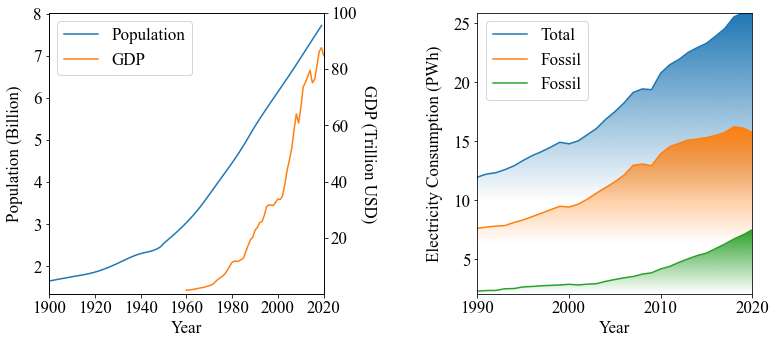

In [103]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

import matplotlib
matplotlib.rcParams['font.size'] = 17
matplotlib.rcParams['font.family'] = 'times new roman'

def clean_elect(series):
    elect = series.World
    elect = elect[pd.notna(elect)]
    x = elect.index
    y = elect.values/1e3
    return x, y

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

ax = axes[1]

gradient_fill(*clean_elect(separated_df['electricity_generation']), fill_color='tab:blue', ax=ax, label='Total')
gradient_fill(*clean_elect(separated_df['fossil_electricity']), fill_color='tab:orange', ax=ax, label='Fossil')
gradient_fill(*clean_elect(separated_df['renewables_electricity']), fill_color='tab:green', ax=ax, label='Fossil')

ax.set_ylabel('Electricity Consumption (PWh)', labelpad=10)
ax.set_xlabel('Year')
ax.set_xlim((1990, 2020))
ax.legend()

ax_pop = axes[0]
ax_gdp = ax_pop.twinx()
(separated_df['population'].World/1e9).plot(ax=ax_pop, color='tab:blue', label='Population')
(df_gdp.World/1e12).plot(ax=ax_gdp, color='tab:orange', label='GDP')

ax_pop.plot([], [], color='tab:orange', label='GDP')

ax_pop.set_xlabel('Year')
ax_gdp.set_ylabel('GDP (Trillion USD)', rotation=270, labelpad=20)
ax_pop.set_ylabel('Population (Billion)', labelpad=10)
ax_gdp.set_ylim((0.1, 100))
ax_gdp.set_xlim((1900, 2020))

ax_pop.set_xticks(range(1900, 2021, 20))
ax_pop.legend()
plt.tight_layout(pad=3)
fig.savefig('figures/population_gdp.pdf', dpi=300)